## This notebook performs exploratory data analysis on a cleaned dataset,here combining train and test splits.

## The purpose is to understand the dataset’s structure, detect potential issues, and identify patterns or relationships that may inform feature engineering and model selection for downstream predictive tasks.

### 1. Import necessary packages, load cleaned data and create one dataframe

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv("../data/processed/train_clean.csv")
test = pd.read_csv("../data/processed/test_clean.csv")

df = pd.concat([train, test], axis=0).reset_index(drop=True)

Matplotlib is building the font cache; this may take a moment.


### 2. Missing value check

Text(142.25, 0.5, 'Fraction of NaNs')

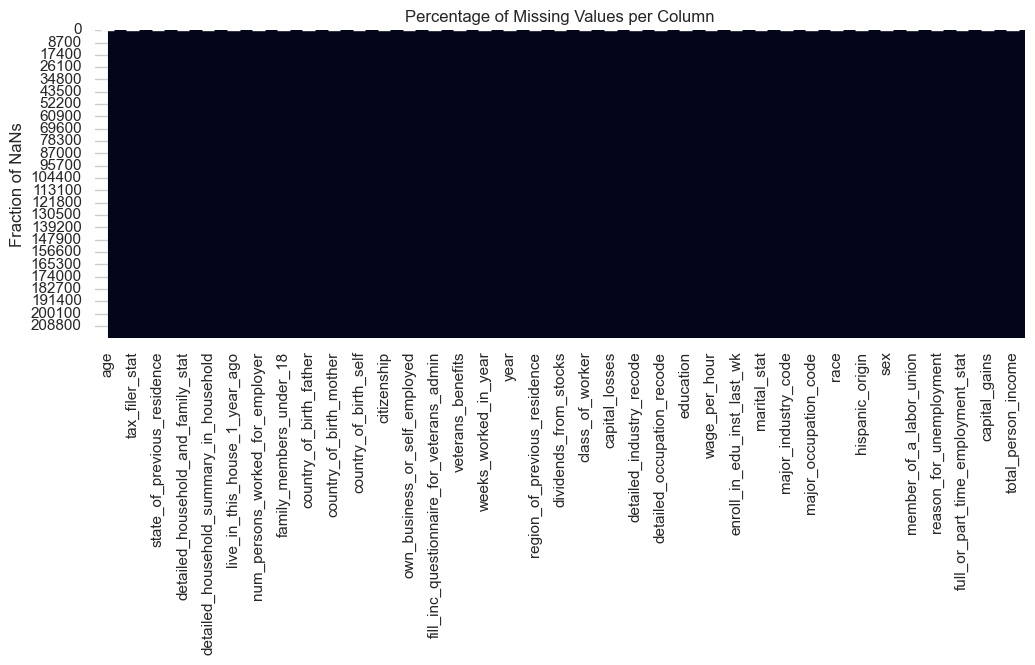

In [ ]:
plt.figure(figsize=(14,5))
sns.heatmap(df.isna(), cbar=False)
na_rate = df.isna().mean().sort_values(ascending=False)
na_rate[na_rate >= 0].plot(kind="bar", figsize=(12,4), color='salmon')
plt.title("Percentage of Missing Values per Column")
plt.ylabel("Fraction of NaNs")


In [30]:
missing_summary = pd.DataFrame({
    "Missing Count": df.isna().sum(),
    "Missing Rate": df.isna().mean()
})
missing_summary[missing_summary["Missing Count"] > 0]

,Missing Count,Missing Rate


No missing value, preprocessed data correct.

### 3. Basic structure

Have a first glance at the data by looking at the first few rows

In [13]:
df.head()

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veterans_benefits,weeks_worked_in_year,year,total_person_income
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


### 4. Class imbalance

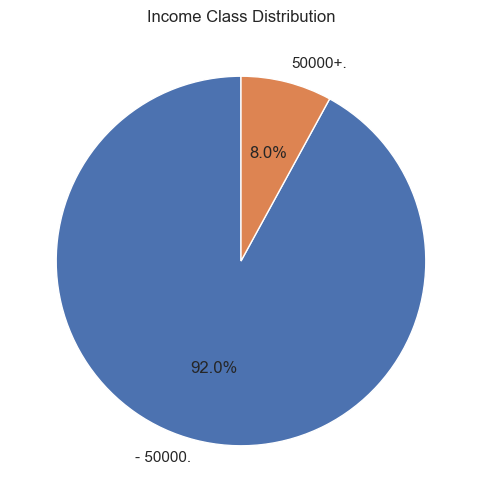

In [32]:
income_counts = df["total_person_income"].value_counts()
plt.figure(figsize=(6,6))
plt.pie(income_counts, labels=income_counts.index, autopct='%1.1f%%', startangle=90,)
plt.title("Income Class Distribution")
plt.show()

Highly imbalanced data, a naive model could achieve over 90% accuracy by always predicting the majority class, without actually learning meaningful patterns.
Solution:
1. Use evaluation metrics that reflect performance on both classes (e.g., F1-score, precision, recall, ROC-AUC) rather than accuracy alone.
2. Consider resampling strategies such as undersampling the majority class or oversampling the minority class to rebalance the training data.

### 5. Numerical features

Examining the distribution of all numeric variables to understand their range, scale, and skewness.
Then, split the data by income class to visualize how each numeric feature differs between individuals earning under $50K and over $50K.

In [15]:
num_cols = [
    "age",
    "wage_per_hour",
    "capital_gains",
    "capital_losses",
    "dividends_from_stocks",
    "num_persons_worked_for_employer",
    "weeks_worked_in_year"
]

df[num_cols].describe()

,age,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,num_persons_worked_for_employer,weeks_worked_in_year
count,217489.000000,217489.000000,217489.000000,217489.000000,217489.000000,217489.000000,217489.000000
mean,39.423327,72.926084,551.130071,47.649950,246.943519,2.560672,30.304236
std,19.434228,311.502834,5246.098471,305.496793,2181.541502,2.403479,23.718906
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,0.000000,0.000000,0.000000,0.000000,2.000000,46.000000
75%,52.000000,0.000000,0.000000,0.000000,0.000000,5.000000,52.000000
max,90.000000,9999.000000,99999.000000,4608.000000,99999.000000,6.000000,52.000000


Most numeric variables (like wage_per_hour, capital_gains, and dividends_from_stocks) have medians of 0 but extremely large maximums, suggesting a few high outliers drive up the mean.

Sparse income-related data — the 75th percentile for all financial variables is still 0, meaning the majority of individuals report no additional income beyond wages.

Weeks_worked_in_year caps at 52 with a median of 46, showing most people work close to a full year, while num_persons_worked_for_employer averages around 2–3, indicating small workplace sizes.

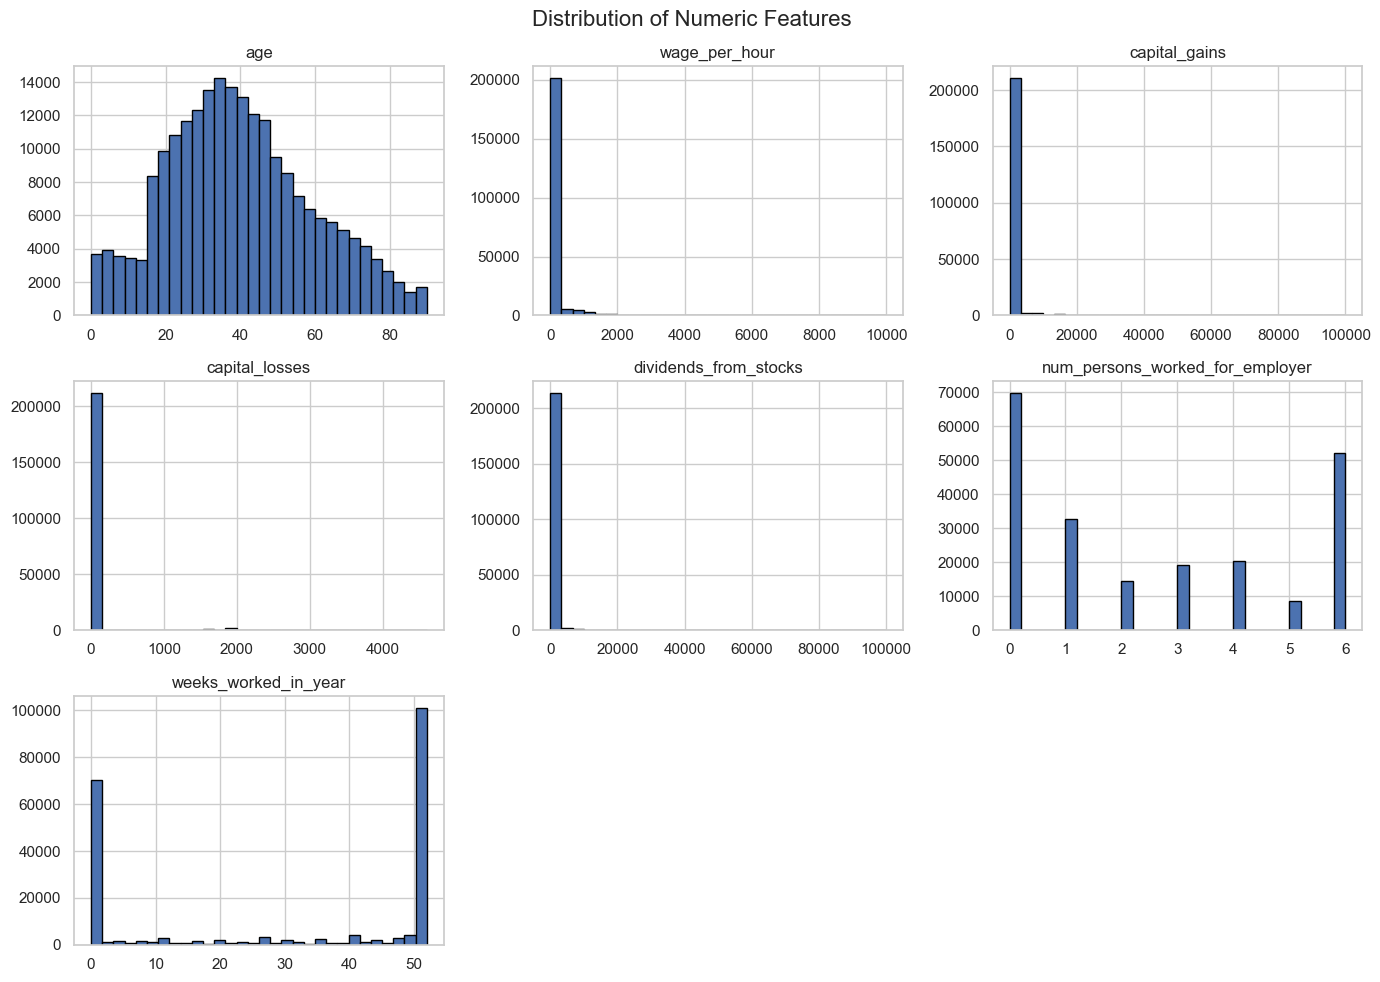

In [36]:
num_cols = [
    "age",
    "wage_per_hour",
    "capital_gains",
    "capital_losses",
    "dividends_from_stocks",
    "num_persons_worked_for_employer",
    "weeks_worked_in_year"
]

df[num_cols].hist(figsize=(14,10), bins=30, edgecolor="black")
plt.suptitle("Distribution of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()


Under 50k: 200171, Over 50k: 17318


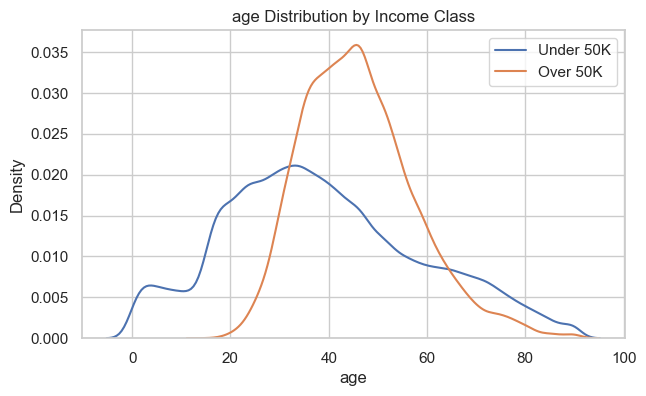

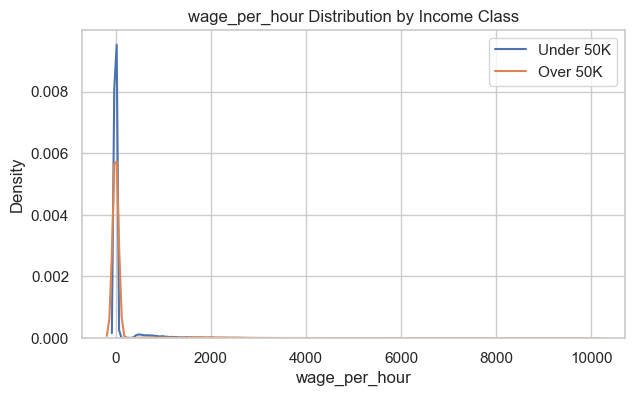

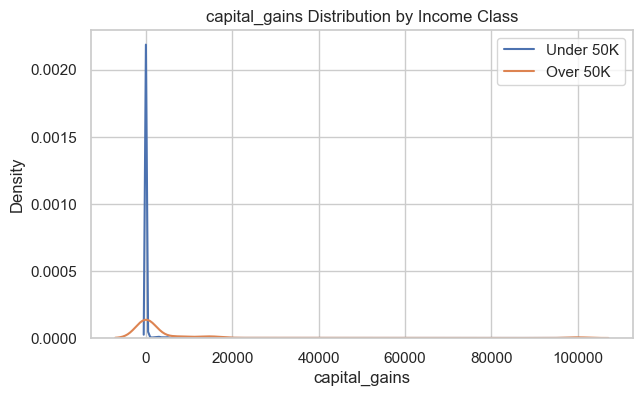

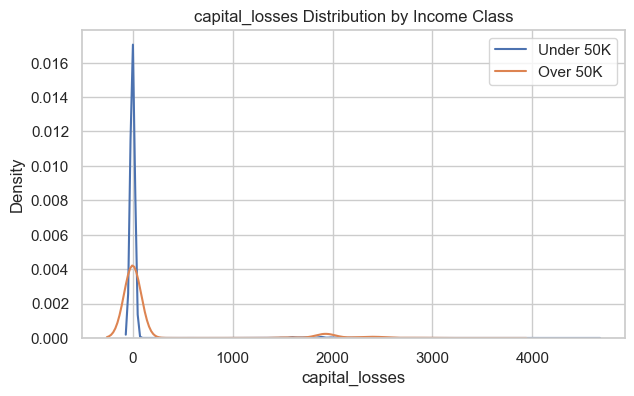

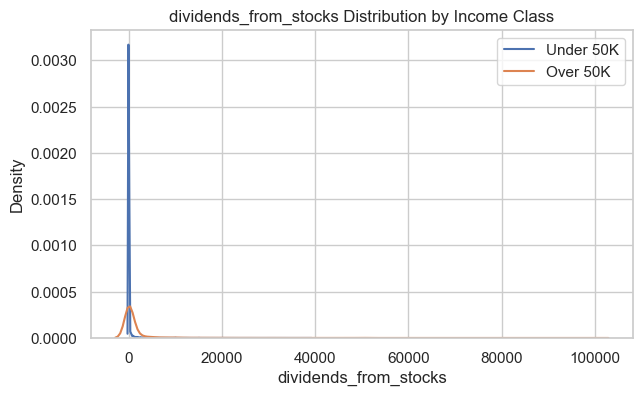

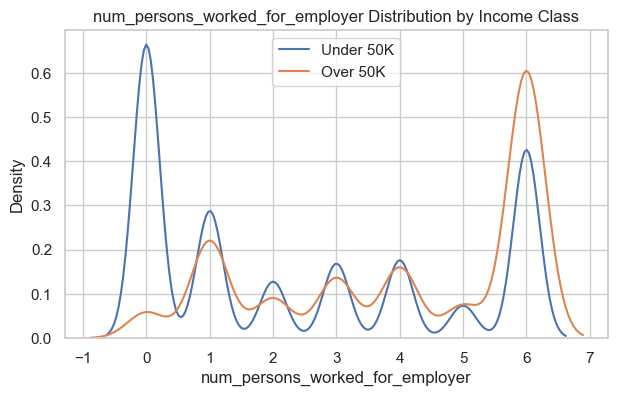

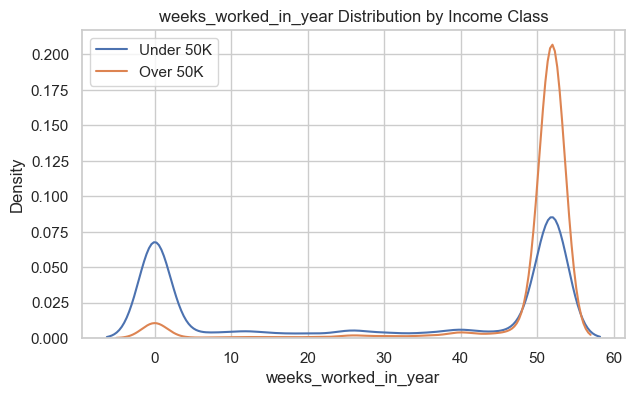

In [38]:
df_low = df[df["total_person_income"] == "- 50000."]
df_high = df[df["total_person_income"] == "50000+."]
print(f"Under 50k: {len(df_low)}, Over 50k: {len(df_high)}")


for col in num_cols:
    plt.figure(figsize=(7,4))
    sns.kdeplot(df_low[col], label="Under 50K")
    sns.kdeplot(df_high[col], label="Over 50K")
    plt.title(f"{col} Distribution by Income Class")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


Most numeric variables are right-skewed, with many zeros indicating sparse financial data.
Higher-income individuals tend to have greater capital gains, dividends, and weeks worked per year, reflecting more consistent employment and investment activity.
Other features like age show a mild positive relationship with income, while wage_per_hour appears largely uninformative.

### 6. Categorial features

Explore how categorical variables relate to income class, then review their frequency distributions, then visualize income proportions within each category.

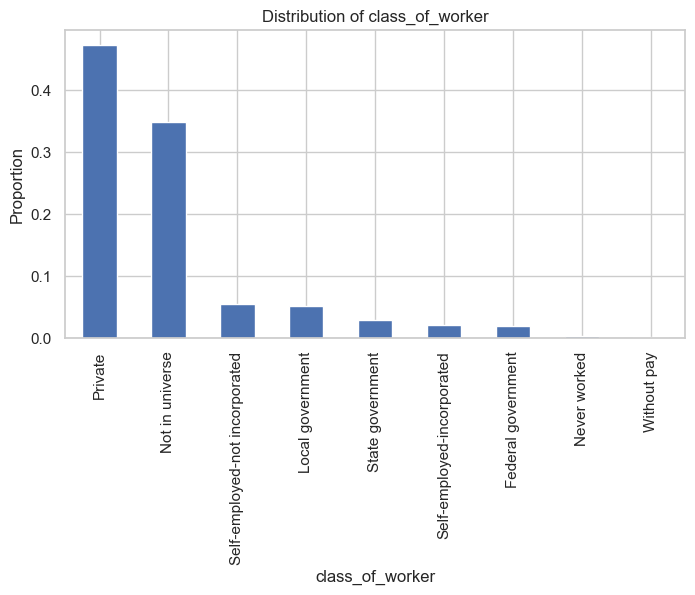

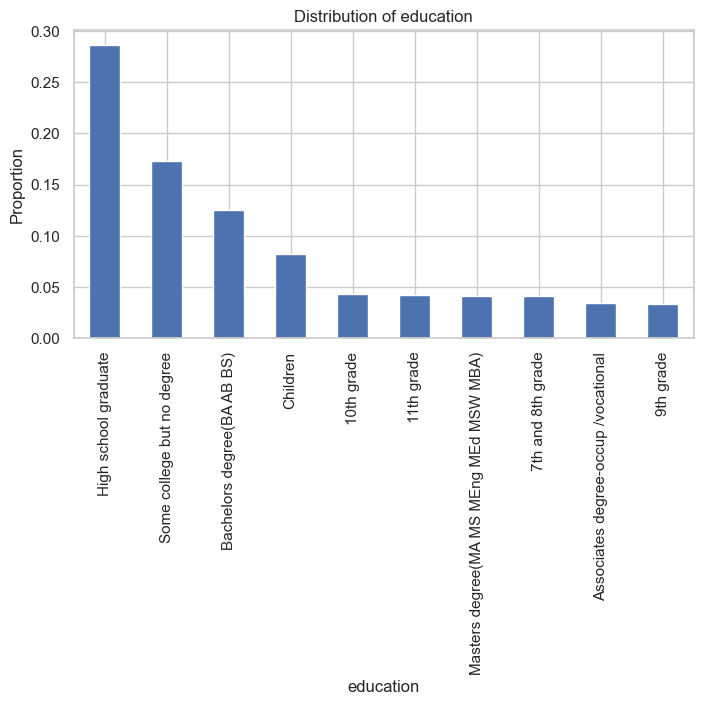

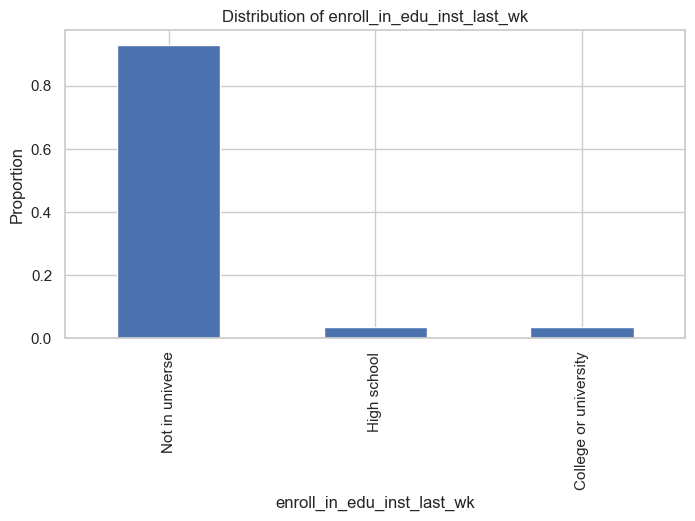

In [ ]:
cat_cols = df.select_dtypes(include="object").columns.tolist()
cat_cols.remove("total_person_income")
# first three categorical columns, remove 3 if needed
for col in cat_cols[:3]:
    plt.figure(figsize=(8,4))
    df[col].value_counts(normalize=True).head(10).plot(kind="bar")
    plt.title(f"Distribution of {col}")
    plt.ylabel("Proportion")
    plt.xlabel(col)
    plt.show()


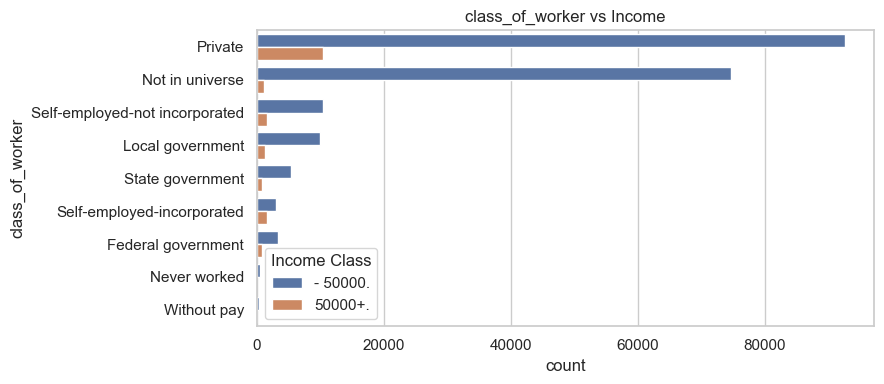

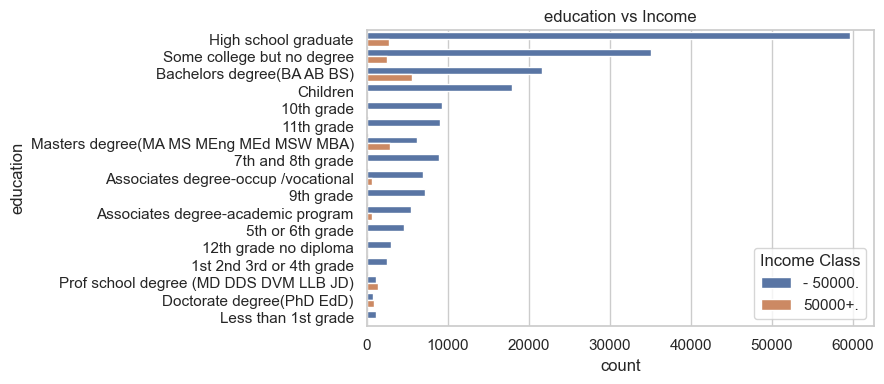

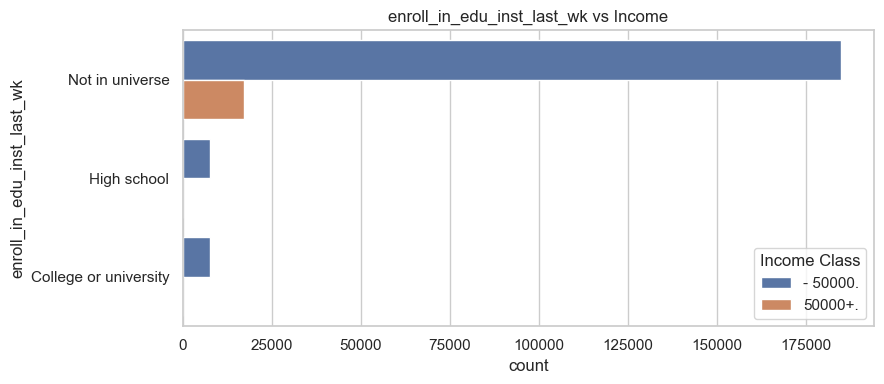

In [45]:
for col in cat_cols[:3]:  # like previous cell, adjust number as needed
    plt.figure(figsize=(9,4))
    sns.countplot(y=col, hue="total_person_income", data=df,
                  order=df[col].value_counts().index)
    plt.title(f"{col} vs Income")
    plt.legend(title="Income Class")
    plt.tight_layout()
    plt.show()


Categorical analysis reveals clear patterns — variables like education, class_of_worker, and marital_stat show distinct differences in income composition.
Higher education levels and self-employment categories are notably more prevalent among higher-income individuals.

### 7. Check correlations

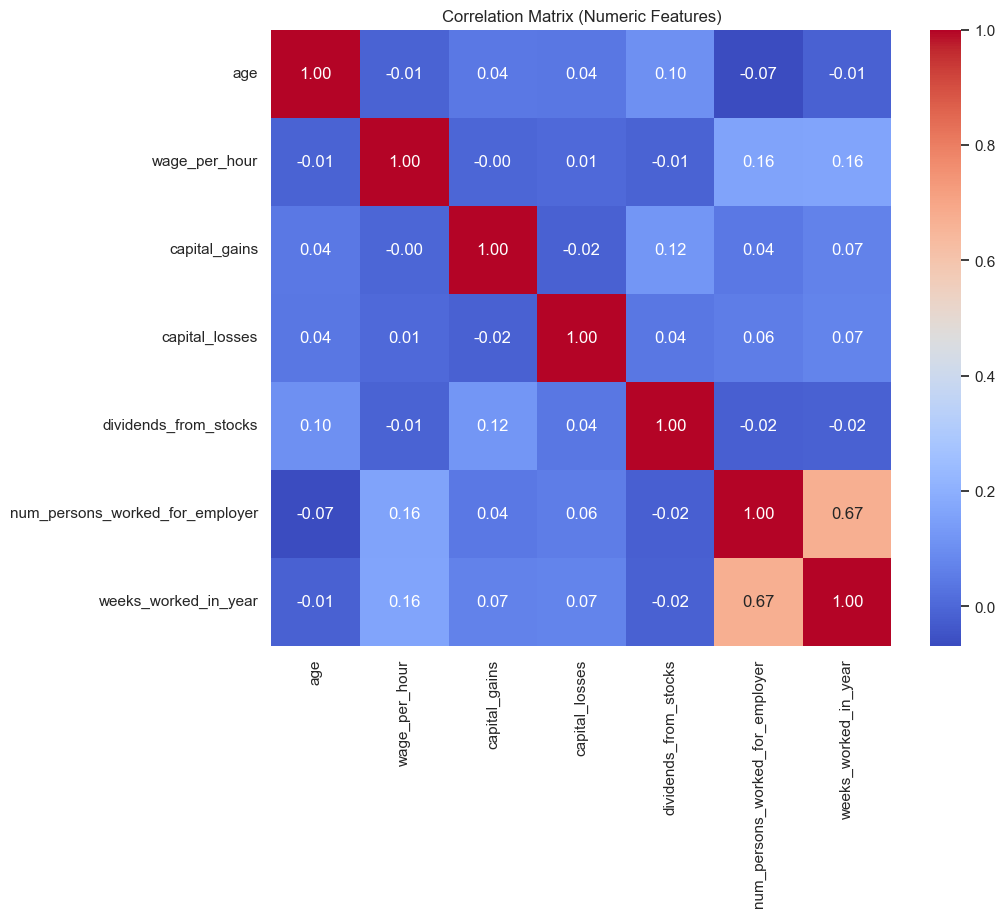

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

show actual correlation (e.g., Point-Biserial correlation) between each numeric variable and income:

In [22]:
from scipy.stats import pointbiserialr

y = df["total_person_income"].map(lambda s: 0 if "-" in s else 1)
corrs = {col: pointbiserialr(df[col], y)[0] for col in num_cols}
pd.Series(corrs).sort_values(ascending=False)


capital_gains                      0.235745
weeks_worked_in_year               0.223970
num_persons_worked_for_employer    0.183055
dividends_from_stocks              0.172946
capital_losses                     0.138550
age                                0.100997
wage_per_hour                      0.007555
dtype: float64

Most numeric features are weakly correlated with each other, except for a moderate link between weeks_worked_in_year and num_persons_worked_for_employer (≈0.67).
When compared with income, capital_gains, weeks_worked_in_year, and dividends_from_stocks show the strongest positive correlations, indicating that financial activity and consistent employment are key factors associated with higher income.

### 9. Feature importance check via RF

Axes(0.125,0.11;0.775x0.77)


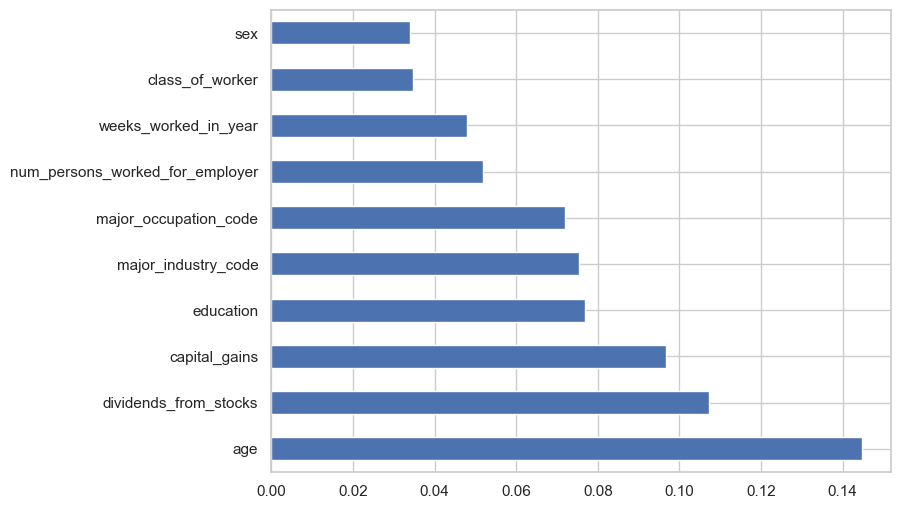

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder

X = OrdinalEncoder().fit_transform(df[cat_cols])
X = np.hstack([X, df[num_cols].fillna(0).values])
y = df["total_person_income"].map(lambda s: 0 if "-" in s else 1)

rf = RandomForestClassifier(random_state=0)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=cat_cols + num_cols)
importances.sort_values(ascending=False).head(10).plot(kind="barh", figsize=(8,6))
plt.title("Preliminary Feature Importance (Random Forest)")
plt.show()


The Random Forest model highlights age, dividends_from_stocks, and capital_gains as the strongest predictors of income, followed by education, industry, and occupation, suggesting that both financial activity and socioeconomic factors play major roles in distinguishing higher-income individuals.